## CPSC 8430 Fall 24 HW 1_2a

#### 1. Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

#### 2. Define the DNN model

In [2]:
class DNN(nn.Module):
    def __init__(self):
        super(DNN, self).__init__()
        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)  # Flatten the input
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

#### 3. Load the MINST dataset

In [3]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])  #0.1307 and 0.3081 are the mean and std of the MINST dataset
train_dataset = datasets.MNIST('./data_MNIST', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

#### 4. Function for collecting Weights

In [4]:
# Function to collect weights of the whole model
def collect_weights(model):
    weights = []
    for param in model.parameters():
        weights.append(param.data.cpu().numpy().flatten()) 
    return np.concatenate(weights)

In [5]:
# Function to collect weights from layer 1 (fc1)
def collect_layer1_weights(model):
    return model.fc1.weight.data.cpu().numpy().flatten()  

In [6]:
# Initialize collections
all_weight_collections = [] 
layer1_weight_collections = []  
all_losses = []  

#### 5. Train the model and collect weights

In [7]:
epochs = 15
train_runs = 8  # Train the model 8 times
pca = PCA(n_components=2)

In [8]:
# Training Loop
for run in range(train_runs):
    print(f"\nTraining run {run + 1}/{train_runs}")
    model = DNN()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    weight_collection = []  # For collecting whole model weights in this run
    layer1_weight_collection = []  # For collecting layer 1 weights in this run
    losses = []  # To track the loss for this run
    
    # Training the model
    for epoch in range(epochs):
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(train_loader):
            optimizer.zero_grad()  
            outputs = model(inputs)  
            loss = criterion(outputs, labels) 
            loss.backward()  
            optimizer.step() 
            
            running_loss += loss.item()
        
        # Collect weights every 3 epochs
        if (epoch + 1) % 3 == 0:
            weights = collect_weights(model)  # Collect whole model weights
            weight_collection.append(weights)
            
            layer1_weights = collect_layer1_weights(model)  # Collect layer 1 weights
            layer1_weight_collection.append(layer1_weights)
        
        # Average loss for the epoch
        avg_loss = running_loss / len(train_loader)
        losses.append(avg_loss)
        print(f'Epoch {epoch + 1}/{epochs}, Loss: {avg_loss}')
    
    # Store weights and losses for this run
    all_weight_collections.append(weight_collection)
    layer1_weight_collections.append(layer1_weight_collection)
    all_losses.append(losses)


Training run 1/8
Epoch 1/15, Loss: 0.23127675202013906
Epoch 2/15, Loss: 0.09602338135558199
Epoch 3/15, Loss: 0.06628731392703252
Epoch 4/15, Loss: 0.05029730841136182
Epoch 5/15, Loss: 0.04063206540779578
Epoch 6/15, Loss: 0.03231205635020626
Epoch 7/15, Loss: 0.030035066043661195
Epoch 8/15, Loss: 0.025518415229587435
Epoch 9/15, Loss: 0.02171890111719216
Epoch 10/15, Loss: 0.019155260067942544
Epoch 11/15, Loss: 0.018404797971025493
Epoch 12/15, Loss: 0.015909543270251864
Epoch 13/15, Loss: 0.01722344989390851
Epoch 14/15, Loss: 0.01390131410642625
Epoch 15/15, Loss: 0.01495044432615855

Training run 2/8
Epoch 1/15, Loss: 0.22928505174434388
Epoch 2/15, Loss: 0.09493495492207041
Epoch 3/15, Loss: 0.0655656618141591
Epoch 4/15, Loss: 0.049961897926697973
Epoch 5/15, Loss: 0.038721276016793954
Epoch 6/15, Loss: 0.03397628578415979
Epoch 7/15, Loss: 0.02616695346722036
Epoch 8/15, Loss: 0.02548628501936735
Epoch 9/15, Loss: 0.021305955253802224
Epoch 10/15, Loss: 0.02149070496124817


#### 6. Convert the list of weights to np array

In [9]:
# Convert the list of weight collections to a single np array
all_weight_collections = np.vstack(all_weight_collections)
print(all_weight_collections)

# Convert the list of layer 1 weight collections to a single np array
layer1_weight_collections = np.vstack(layer1_weight_collections)

[[-0.01240629  0.00574183 -0.02580752 ... -0.01067705  0.15063204
   0.0640611 ]
 [ 0.00218457  0.02033265 -0.01121669 ... -0.04565165  0.23716728
   0.08112982]
 [-0.00166697  0.01648106 -0.01506821 ... -0.08432045  0.32326794
   0.09959907]
 ...
 [ 0.0313295   0.06200729  0.0306622  ... -0.05841904  0.29058033
   0.10031181]
 [ 0.03733074  0.06800844  0.03666342 ... -0.09575976  0.3670074
   0.10695585]
 [ 0.04354236  0.07422018  0.04287505 ... -0.11231948  0.42924336
   0.12028516]]


#### 7. Apply PCA

In [10]:
# Apply PCA to reduce to 2 dimensions for whole model
weights_pca = pca.fit_transform(all_weight_collections)

# Apply PCA to reduce to 2 dimensions for layer 1
layer1_weights_pca = pca.fit_transform(layer1_weight_collections)

#### 8. Plotting PCA results

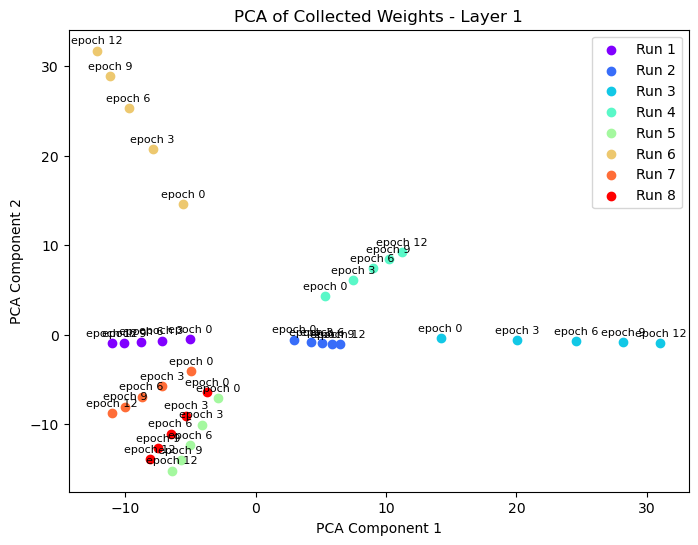

In [20]:
# For layer 1
run_epochs = 5
train_runs = 8

# Create a colormap based on training runs
colors = plt.cm.rainbow(np.linspace(0, 1, train_runs))

plt.figure(figsize=(8, 6))

# Iterate over each run and plot separately
for run in range(train_runs):
    start_idx = run * run_epochs
    end_idx = (run + 1) * run_epochs
    plt.scatter(layer1_weights_pca[start_idx:end_idx, 0], layer1_weights_pca[start_idx:end_idx, 1], 
                color=colors[run], label=f'Run {run + 1}')
    
    # labelling with epoch numbers
    for i in range(start_idx, end_idx):
        epoch_num = (i % run_epochs) * 3  # Adjust epoch labeling
        plt.annotate(f'epoch {epoch_num}', (layer1_weights_pca[i, 0], layer1_weights_pca[i, 1]), 
                     textcoords="offset points", xytext=(0, 5), ha='center', fontsize=8)

plt.title('PCA of Collected Weights - Layer 1')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(loc='upper right')
plt.show()

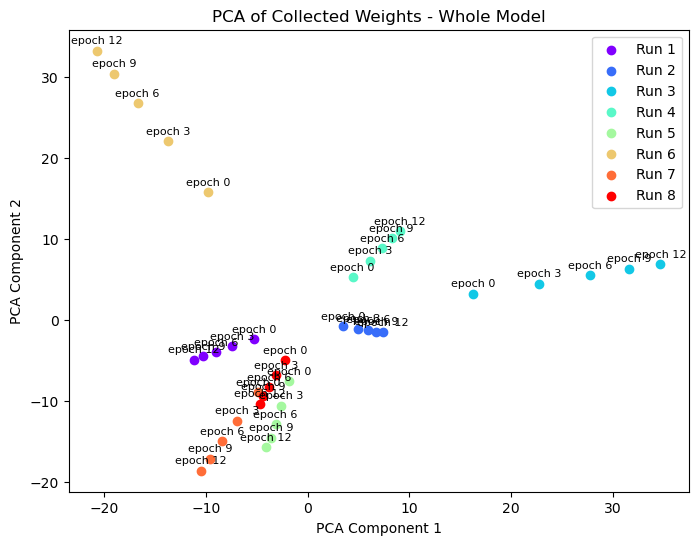

In [21]:
# For whole model
plt.figure(figsize=(8, 6))

# Iterate over each run and plot separately
for run in range(train_runs):
    start_idx = run * run_epochs
    end_idx = (run + 1) * run_epochs
    plt.scatter(weights_pca[start_idx:end_idx, 0], weights_pca[start_idx:end_idx, 1], 
                color=colors[run], label=f'Run {run + 1}')
    
    # labelling with epoch numbers
    for i in range(start_idx, end_idx):
        epoch_num = (i % run_epochs) * 3  # Adjust epoch labeling
        plt.annotate(f'epoch {epoch_num}', (weights_pca[i, 0], weights_pca[i, 1]), 
                     textcoords="offset points", xytext=(0, 5), ha='center', fontsize=8)

plt.title('PCA of Collected Weights - Whole Model')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(loc='upper right')
plt.show()

#### 9. Plot loss curves for each train run

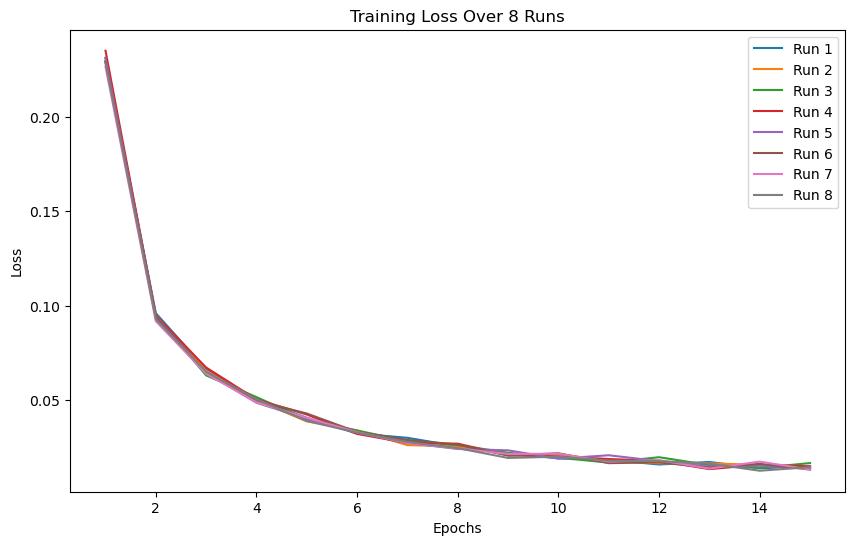

In [14]:
plt.figure(figsize=(10, 6))
for run in range(train_runs):
    plt.plot(range(1, epochs + 1), all_losses[run], label=f'Run {run + 1}')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over 8 Runs')
plt.legend()
plt.show()